# ABOVE | AC9 Data Processing
***
## Step 01 Read AC9 files
***

**Authors:** Catherine Kuhn and Elena Terzić and Anna Simpson
**Last Updated:** August, 29th, 2018
***

This code reads in raw ac9 .dat files and parses sample information from the filename and header information inside the file. The output is a table of summary statistics formatted as a *.csv* file for each wavelength for each file. This code was built for a worflow in which a and c sides are sampled separately. File names should contain: date, site, rep, a or c side and water temperature. 

File names are formatted like ** AC9_dddddd_sit_sam_s_r_TXX_XX.dat** where:

- **dddddd** = date (071718)
- **sit** = three letter site code (fai)
- **sam** = three letter sample type (cal, raw, fil) for calibration, raw water (unfiltered) or filtered (fil)
- **r** = numbered replicate (1, 2, 3) 
- **TXX_X** = temperature in Celcius (T17_3)
    
**Ex:** AC9_071618_y17_raw_a_1_T17_6.dat



### Load required packages

In [179]:
### Import the required python libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import matplotlib.pylab as plt
import glob
import os
import sys
import csv
import scipy.stats

In [180]:
## from: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

### Inputs

In [2]:
### Define directory where raw data is located
raw_data_directory = "1_1_renamed_originals"
### New directory name to store summary data
new_dir_name = '2_summary_stats'
### Directory name to stored cleaned raw data if only parts of the time series should be used
cleaned_raw_data_name = '1_2_cleaned_originals'
## Name for original metadata file which will be retained for posterity
metadata_original_name = 'project_metadata_original.csv'
## Name for copy of original metadata file which we will add to later
metadata_updated_name = 'project_metadata_updated.csv'

### Create new file paths and directories for referencing inputs and storing output

In [3]:
### Will be operating from Code directory - this gets parent directory path
parent_directory = os.path.abspath('..')
### Get path to raw data
raw_data_file_path = parent_directory+'/Data/'+raw_data_directory
### Get path to original metadata file that you will create for reference and not touch again
metadata_original_filepath = parent_directory+'/Metadata/'+metadata_original_name
### Get path to updatable metadata file that you will add to
metadata_updated_filepath = parent_directory+'/Metadata/'+metadata_updated_name
## Get full path name of new directory
new_dir_path = os.path.abspath('..')+'/Data/'+new_dir_name
cleaned_raw_data_path = os.path.abspath('..')+'/Data/'+cleaned_raw_data_name


### Create metadata directory
if not os.path.exists(parent_directory+'/Metadata'):
    os.makedirs(parent_directory+'/Metadata')
    
## Get full path name of new directory
new_dir_path = os.path.abspath('..')+'/Data/'+new_dir_name

## Generate new directory if it doesn't already exist
if not os.path.exists(new_dir_path):
    os.makedirs(new_dir_path)
    
## Generate new directory if it doesn't already exist
if not os.path.exists(cleaned_raw_data_path):
    os.makedirs(cleaned_raw_data_path)

## Create metadata csv

In [4]:
basenames = []
date = []
site = []
sample_type = []
abs_type = []
rep = []
temp = []
raw_file_path = []


file_list = sorted(glob.glob(raw_data_file_path+'/*.dat'))
for j in file_list:
    basename = j.split('/')[-1].split('.')[0]
    ## We are excluding the field measurements of filtered data here because theyw ere not good 
    if 'field' in basename:
        continue
    basenames.append(basename)
    Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2= basename.split('_')
    T = float(T1.lstrip('T')+'.'+T2)
    date.append(Date)
    site.append(Site)
    sample_type.append(Sample_Type)
    abs_type.append(Abs_Type)
    rep.append(Rep)
    temp.append(T)
    raw_file_path.append(j)

df = pd.DataFrame(
    {'Sensor':'AC9',
     'ID':basenames,
     'Date': date,
     'Site': site,
     'Sample_Type': sample_type,
     'Analysis_Type': abs_type,
     'Rep': rep,
     'Temp': temp,
     'Raw_File_Path':raw_file_path
    })

df.to_csv(metadata_original_filepath, sep='\t',index=False)
df.to_csv(metadata_updated_filepath, sep='\t',index=False)

### Generate summary statistics and make new csv files for each sample

#### Use the columns in the upper part of the document for the wavelengths. Just to organize your main dataframe. 

In [190]:
# iterate through the raw files
metadata = pd.read_csv(metadata_updated_filepath, skiprows=0, delimiter= '\t')
cleaned_raw_file_path = []
averaged_file_path = []
conf = []

for file_path in metadata['Raw_File_Path']:
# brings in file
    ### Some field filtered measurements sneakily made it through; we shall eliminate them
    if 'field' in file_path.split('/')[-1]:
        continue
    read_wl = pd.read_csv(file_path, skiprows=10, names=range(100), delimiter= '\t')  # use names= range (100) to clip dangling columns
    # reads in a and c wavelength values from the first column of data
    a_c_wl = read_wl[0][0:18]  ; a_wl = read_wl[0][0:9] ; c_wl = read_wl[0][9:18];

    # make empty objects for your new variables of the wavelength value and name
    # Example: wl_a: 650.0; wl_a_str: a650
    wl_a = []    ; wl_c = []  ; wl_a_str = []  ; wl_c_str = []

    # makes a list of the 9 wavelengths formatted as floats
    for i in range(len(a_wl)):
        wl_a.append(np.float(a_wl[i][1:4]))
        wl_a_str.append(a_wl[i])
    for j in range(len(c_wl)):
        wl_c.append(np.float(c_wl[j+9][1:4]))
        wl_c_str.append(c_wl[j+9])

     # Unsorted list of wavelengths (412) and wavelength strings (a676)
    wavelist = wl_a + wl_c                   ; wavelist_str = wl_a_str + wl_c_str   
    # Unsorted list of wavelengths (412) and wavelength strings (a676) as arrays
    wavelengths = np.asarray(wavelist)       ; wavelengths_str = np.asarray(wavelist_str)  
    # Sorted list of a and c wavelengths as floats in an array (ex: 412, 440, etc)
    wl_a_sorted = np.asarray(sorted(wl_a))   ; wl_c_sorted = np.asarray(sorted(wl_c))

    # Now read back in the data, skipping all the header information  
    # The time series of measured values starts in the 32th row
    df1 = pd.read_csv(file_path, skiprows=31, delimiter= '\t') 

    # drops all the ragged extra columns dangling to the right
    columns = df1.columns[19:len(df1.columns)]                 
    df2 = df1.drop(columns, axis=1)    # you should have 19 cols left ~ array size [ntimesteps, 19]                       

    # drops the first column of the timestamp (ntimesteps)
    columns1 = df2.columns[0]
    df3 = df2.drop(columns1, axis=1)                    

    # makes a new header from the list of wavelengths you parsed earlier  
    wl_header = wavelengths_str 

    # Clean and reindex
    df4 = df3[1:]                                       # take the data (row 1- n) less the header row (row 0)
    df4.columns = wavelengths_str                       # set the header row as list of wavelengths
    df4 = df4.reindex_axis(sorted(df4.columns), axis=1) # reindex them by the new sorted wavelengths
    df4=df4.convert_objects(convert_numeric=True)       # Just to make sure that all elements are floats!

    no_cols = int(len(df4.columns)/2.)                  # no_col should always be 9 (one for each wavelength)         

    # Sort your dataframe with ascending walues of your wavelengths
    # at this point the wl_a and wl_c are the same wavelengths so 
    # it doesn't matter which one you use here
    new_header = wl_a_sorted

    # reindex to reshape the data
    df_a_aux = df4.iloc[:, :no_cols];  df_a_aux.columns = new_header ;  df_a = df_a_aux.reindex_axis(sorted(df_a_aux.columns), axis = 1)
    df_c_aux = df4.iloc[:, no_cols:];  df_c_aux.columns = new_header ;  df_c = df_c_aux.reindex_axis(sorted(df_c_aux.columns), axis = 1)

    # calculate the me(di)an, stdev, IQR for the time series - per each column
    a_mean = df_a[wl_a_sorted].mean(axis=0)         ; c_mean = df_c[wl_c_sorted].mean(axis=0)   
    a_std  = df_a[wl_a_sorted].std(axis=0)          ; c_std  = df_c[wl_c_sorted].std(axis=0)
    a_median = df_a[wl_a_sorted].median(axis=0)     ; c_median = df_c[wl_c_sorted].median(axis=0)
    a_var = df_a[wl_a_sorted].var(axis=0)           ; c_var = df_c[wl_c_sorted].var(axis=0)
    a_conf = mean_confidence_interval(df_a[wl_a_sorted]) ; c_conf = mean_confidence_interval(df_c[wl_c_sorted])

    # Computing IQR
    a_Q1 = df_a[wl_a_sorted].quantile(0.25)         ; c_Q1 = df_c[wl_c_sorted].quantile(0.25)
    a_Q3 = df_a[wl_a_sorted].quantile(0.75)         ; c_Q3 = df_c[wl_c_sorted].quantile(0.75)
    a_IQR = a_Q3 - a_Q1                             ; c_IQR = c_Q3 - c_Q1

    # Specifiy the output file name and directory
    metadata_row = metadata.loc[metadata['Raw_File_Path']==file_path]
    ID = metadata_row['ID'].max()
    sensor = metadata_row['Sensor'].max()
    date = metadata_row['Date'].max()
    site = metadata_row['Site'].max()
    sample_type = metadata_row['Sample_Type'].max()
    analysis_type = metadata_row['Analysis_Type'].max()
    
    # Removing temperature information from sample name because it is already recorded elsewhere
    outputname = ID+ '.csv'
    outputdir = new_dir_path+'/'+ outputname 
    cleaned_raw_outputdir = cleaned_raw_data_path+'/'+'cleaned_raw_'+outputname 
    cleaned_raw_file_path.append(cleaned_raw_outputdir)
    averaged_file_path.append(outputdir)

    # make a new dataframe from the summary statistics and export
    if analysis_type == 'a':
        conf.append(a_conf)
        df_a.to_csv(cleaned_raw_outputdir, sep='\t',index=False)
        output_df = pd.DataFrame([wl_a_sorted, a_mean, a_std, a_median, a_var, a_IQR]).swapaxes(0,1)
        output_df.columns = ('wl', 'a_mean', 'a_std', 'a_median', 'a_var','a_IQR')
        output_df.to_csv(outputdir, sep='\t',index=False)
    else:
        conf.append(c_conf)
        df_c.to_csv(cleaned_raw_outputdir, sep='\t',index=False)
        output_df = pd.DataFrame([wl_c_sorted, c_mean, c_std, c_median, c_var, c_IQR]).swapaxes(0,1)
        output_df.columns = ('wl', 'c_mean', 'c_std', 'c_median', 'c_var','c_IQR')
        output_df.to_csv(outputdir, sep='\t',index=False)
metadata['Cleaned_raw_file_path'] = cleaned_raw_file_path
metadata['Averaged_file_path'] = averaged_file_path
metadata['Conf'] = [max(i) for i in conf]
metadata.to_csv(metadata_updated_filepath, sep='\t',index=False)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:54: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


### Graphing standard deviations over time

### Input:

In [146]:
### Pick a size of window over which to calculate standard deviation
window_size = 50

#### Read in metadata

In [135]:
metadata = pd.read_csv(metadata_updated_filepath, skiprows=0, delimiter= '\t')

#### Function to generate standard deviations for cleaned raw data - takes rolling standard deviation using a user-specified window size for each wavelength, then averages the standard deviations to get a mean standard deviation. Returns a dataframe.

In [136]:
def get_std_means(filepath_to_csv, window_size):
    example = pd.read_csv(filepath_to_csv, skiprows=0, delimiter= '\t')
    #example_means = example.rolling(window=window_size).mean()[window_size-1:]
    example_std = example.rolling(window=window_size).std()[window_size-1:]
    example_std = example_std.reset_index()
    example_std = example_std.rename(columns = {'index':'time'})
    example_std['time'] = example_std['time'].apply(lambda x: (x+2)-window_size)
    example_std['mean'] = example_std[example_std.columns[1:]].mean(axis=1)
    return example_std

#### Function to plot rolling average standard devitation, pooling the filtered, raw, and calibrated for each site with separate plots for attenuation and absorbance

In [168]:
def plotting_rolling_avg(list_of_lists, window, title='Title'):
    labels_list = []
    for mylist in list_of_lists:           
            repname = mylist[0]
            labels_list.append(repname)
            if 'fil' in repname:
                linestyle = '--'
            if 'raw' in repname:
                linestyle = '-'
            if 'cal' in repname:
                linestyle = ':'
            plt.plot('time','mean',data=mylist[1],label=repname,linestyle=linestyle)
            #plt.scatter('wl', 'a_mean', data = df)
    myylabel = 'Start position for getting St. Dev. (end = start + %s)' % window
    plt.ylabel(myylabel)
    plt.title(title)
    plt.legend(labels_list)
    return plt

#### Generates a dictionary using metadata information which puts samples into order for plotting

In [150]:
metadata['SiteDate'] = metadata["Site"] + '_' + metadata["Date"].map(str)
file_dict = {}
for index, row in metadata.iterrows():
    SiteDate = row['SiteDate']
    Filepath = row['Cleaned_raw_file_path'] 
    Analysis_Type = row['Analysis_Type']
    repname = row['Sample_Type']+' '+str(row['Rep'])
    if SiteDate not in file_dict:
        file_dict[SiteDate] = {'a':[], 'c':[]}
    std_dataframe = get_std_means(Filepath,window_size)
    if Analysis_Type == 'a':
        file_dict[SiteDate]['a'].append([repname,std_dataframe])
    if Analysis_Type == 'c':
        file_dict[SiteDate]['c'].append([repname,std_dataframe])

# NOTE for problem that needs to be fixed: using the 'subplots' command, when I plot for the first time on the kernel a blank plot is the first to appear. Not sure why. Ideas?

### Making pretty plots

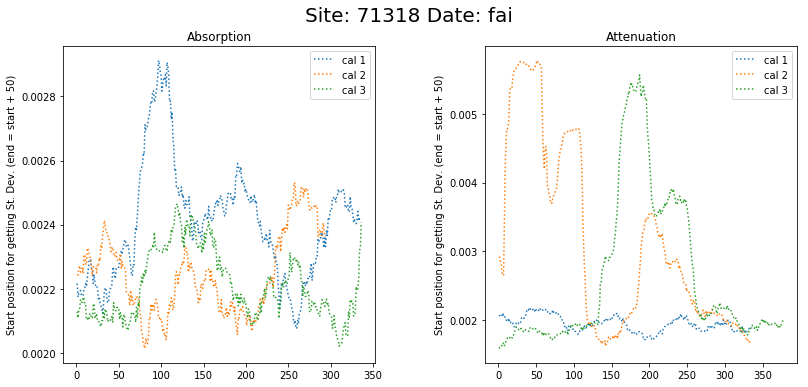

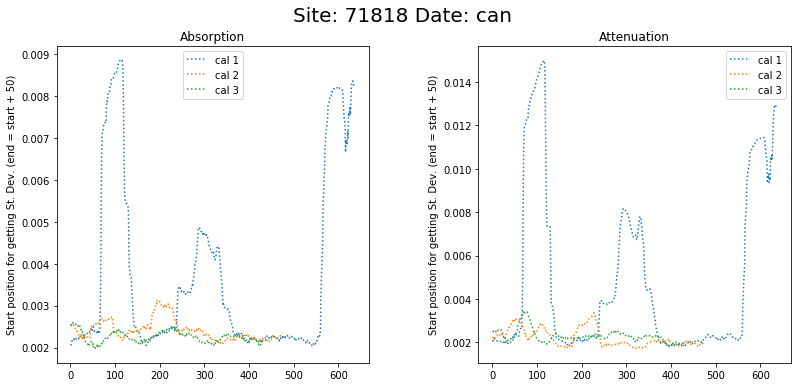

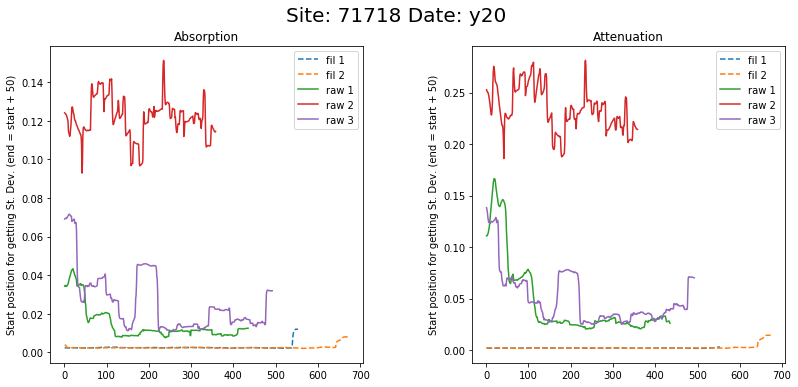

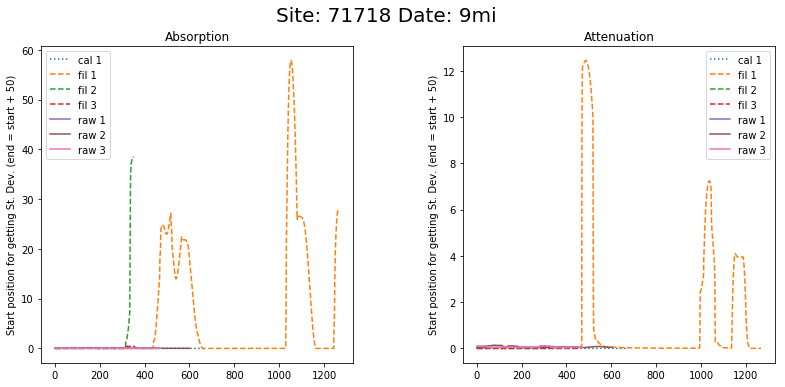

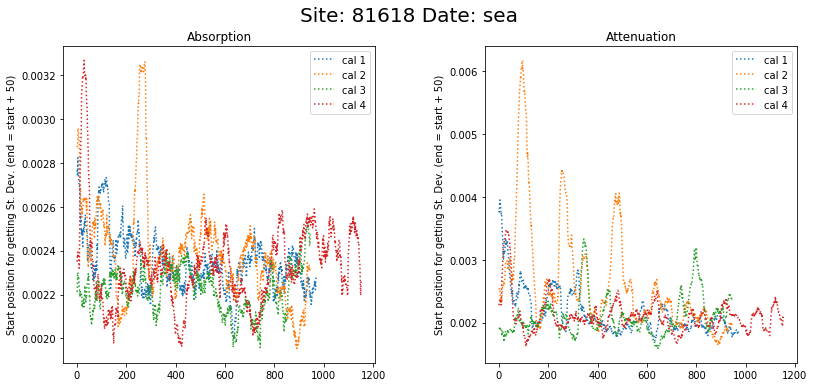

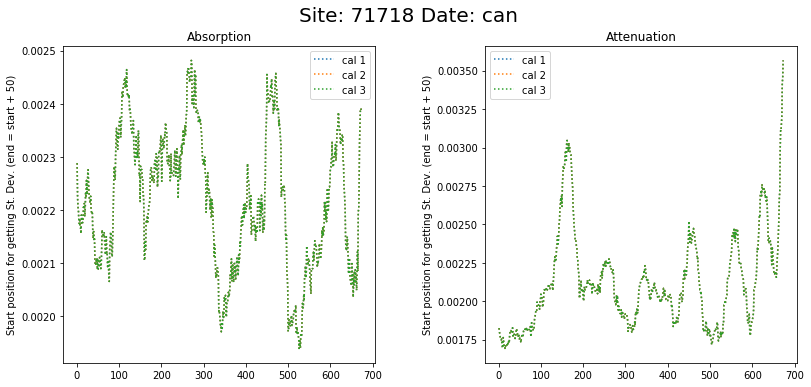

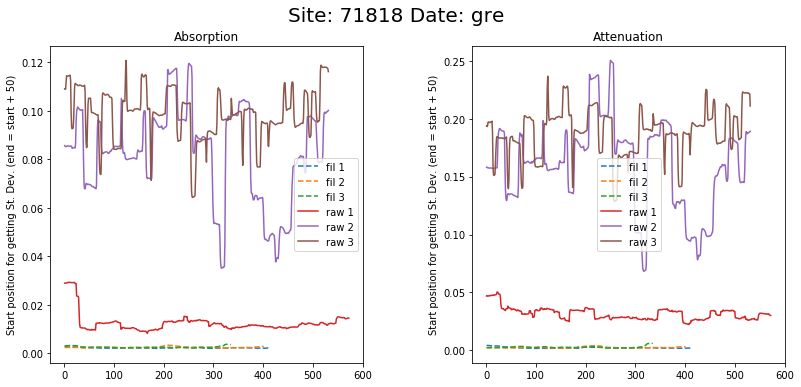

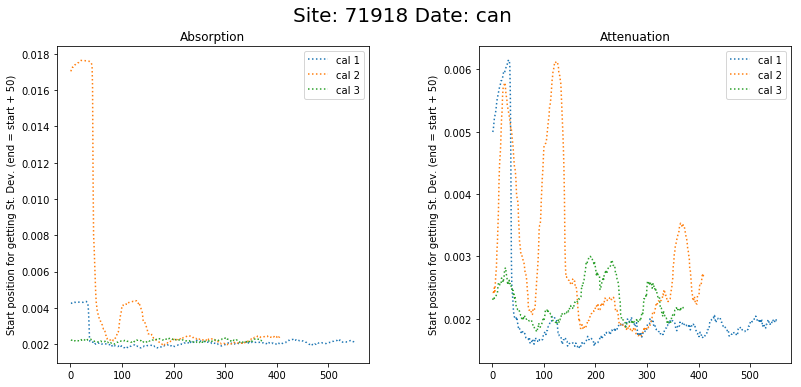

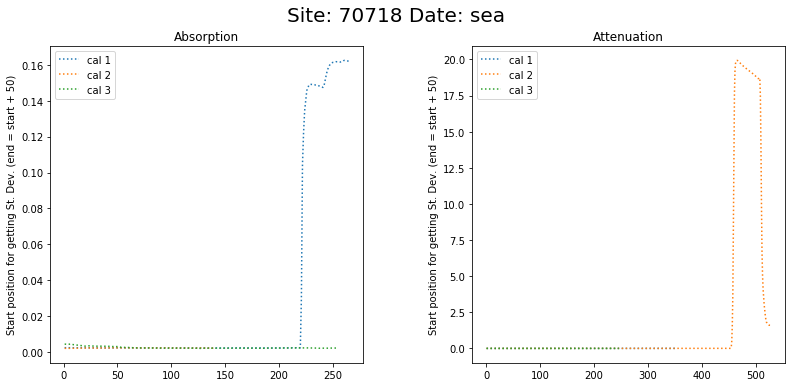

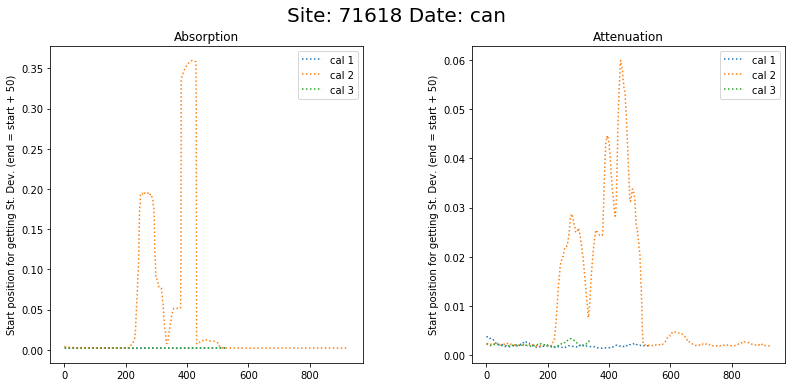

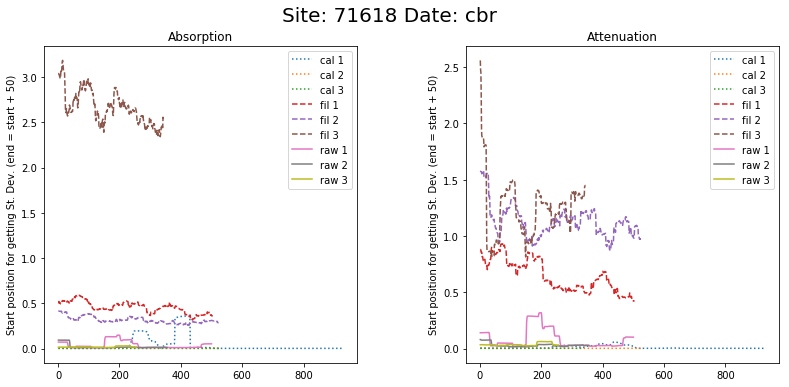

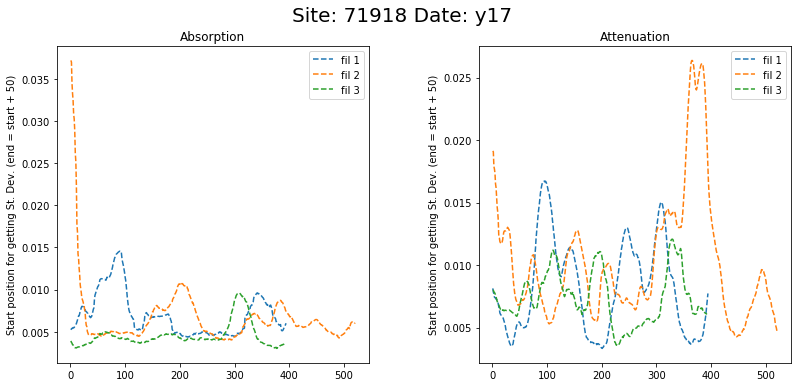

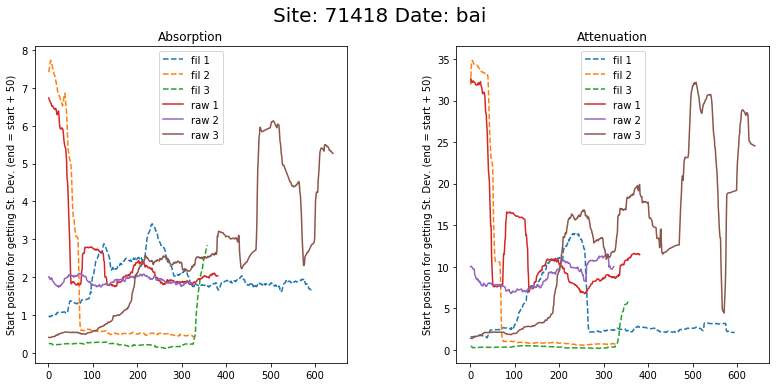

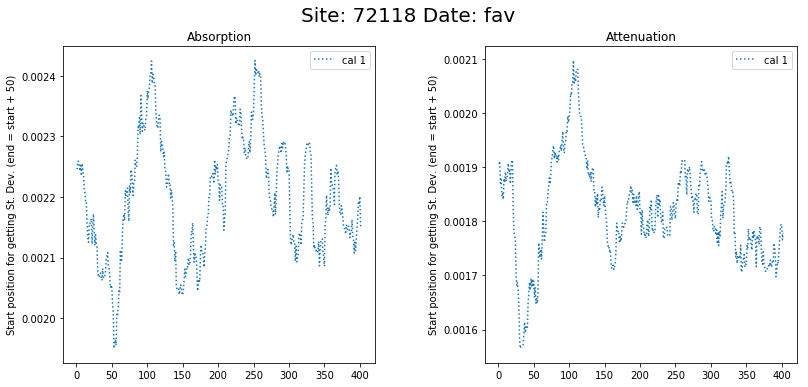

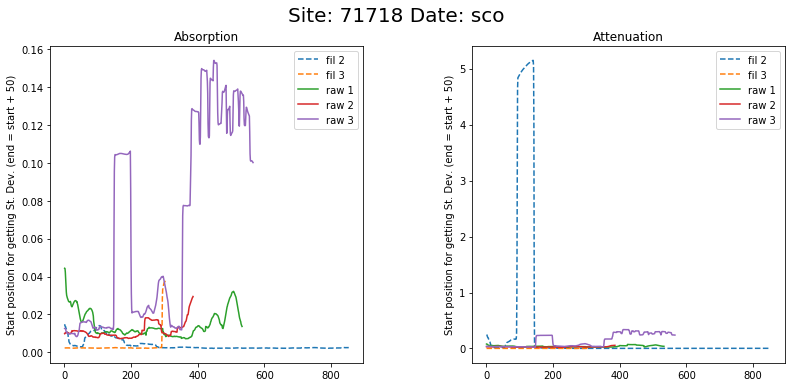

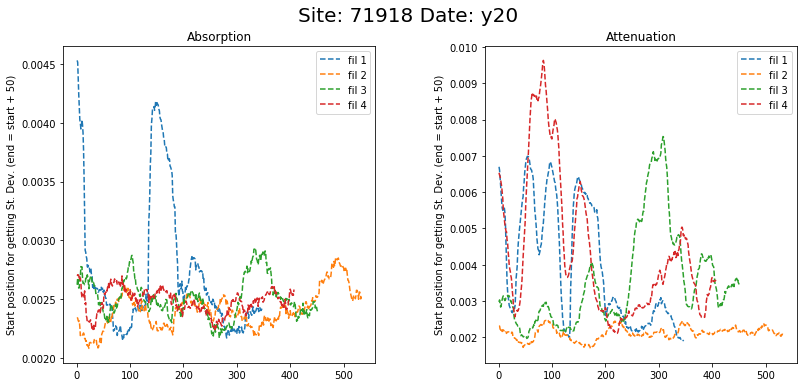

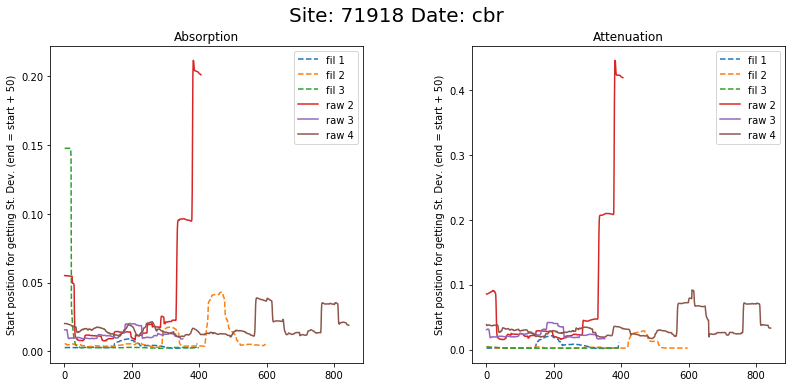

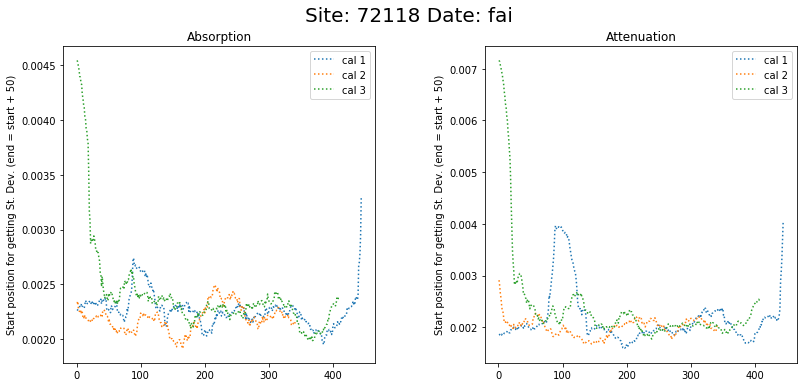

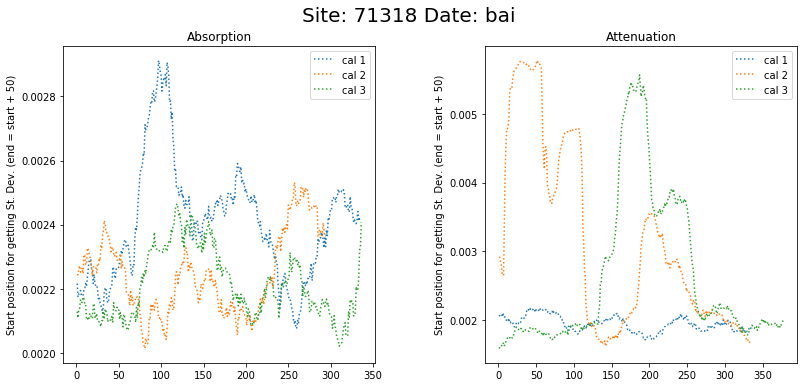

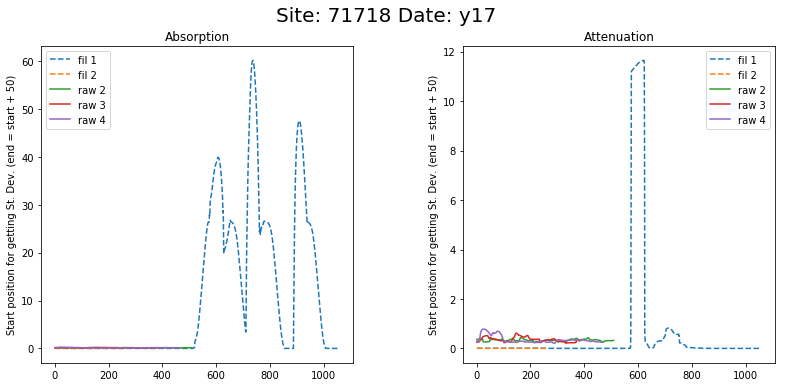

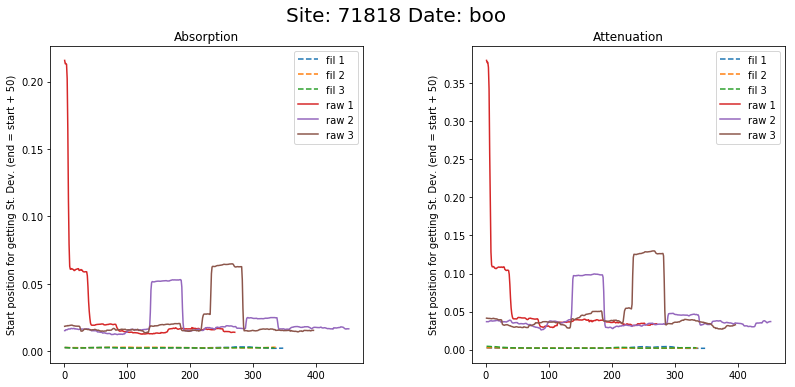

In [170]:
sample_types = {'fil':"Filtered",'raw':'Unfiltered (Raw)','cal':"Calibration"}
abs_types = {'a':'Absorption','c':'Attenuation'}
types_list = ['a','c']

for i in file_dict:
    Date_all, Site_all = i.split('_')
    plt.subplots(1, 2, figsize=(12, 5.5))
    count = 0
    for j in types_list:
        count += 1
        plt.subplot(1, 2, count)    
        my_plot = plotting_rolling_avg(file_dict[i][j], title=abs_types[j], window = window_size)
        #dict_of_sampleids_and_plots[sampleid] = my_plot
    plt.subplots_adjust(top=0.88, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
    my_plot.suptitle('Site: '+Site_all+' '+'Date: '+Date_all, fontsize=20)
    my_plot.show()